In [18]:
from model.DLPG import DLPG
from model.DLPG_MDN import DLPG_MDN
from model.SAC import SAC
from model.PPO import PPO
from utils.dataloader import Buffer, Sampler
from envs.reacherEnv import CustomReacherEnv

from utils.args import read_ARGS
from utils.tools import cast_numpy

import numpy as np
from pathlib import Path
import torch

# Load info
model = "PPO"      #[DLPG, DLPG_MDN, SAC, PPO], 
sample = "random"  #[random.py, dpp.py, Fdpp.py]
path = Path("../results")/model/f"{model}_{sample}"
seed = 0
iter_num = 4_000

LOAD_WEIGHTPAHT = path/f"seed_{seed}"/"weights"/f"{iter_num+1}.pth"
assert path.is_dir()
assert Path.is_file(LOAD_WEIGHTPAHT)

In [19]:
args = read_ARGS(path/"args.py")

# Model
if args.model == "DLPG":
    model = DLPG(args=args).to(args.device)
elif args.model == "DLPG_MDN":
    model = DLPG_MDN(args=args).to(args.device)
elif args.model == "SAC":
    model = SAC(args=args).to(args.device)
elif args.model == "PPO":
    model = PPO(args=args).to(args.device)
else:
    raise LookupError

# Load Weight
model.load_state_dict(torch.load(LOAD_WEIGHTPAHT),strict=True)


env = CustomReacherEnv(Kp=args.Kp, Kd=args.Kd, jointlimit=cast_numpy(args.jointlimit))

test_buffer = Buffer(
    anchor_dim=args.anchor_dim, last_position_dim=args.position_dim, buffer_limit=args.eval_batch_size)

# Sampler
sampler = Sampler()

/home/taerim/.local/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


In [20]:
### Evaluating ###
model.eval()
# Empty and Fill test_buffer
test_buffer.empty()

for _ in range(args.eval_batch_size):
    target_quadrant = np.random.randint(0,4)
    
    # ROLL OUT
    if args.model in ["DLPG", "DLPG_MDN"]:
        (anchor, rejection_rate), (reward,_,last_position,_) = model.rollout(env, target_quadrant, True, args.lentraj, args.RENDER_ROLLOUT)
        test_buffer.store(anchor, reward, target_quadrant, last_position)

    elif args.model == "SAC":
        (anchor, rejection_rate), (reward,_,last_position,_) = model.rollout(env, target_quadrant, args.lentraj, args.RENDER_ROLLOUT)
        test_buffer.store(anchor, reward, target_quadrant, last_position)
        
    elif args.model == "PPO":
        (anchor, log_p, value, rejection_rate), (reward,_,last_position,_) = model.rollout(env, target_quadrant, args.lentraj, args.RENDER_ROLLOUT)
        test_buffer.store(anchor, reward, target_quadrant, last_position, log_p, value)
    else:
        raise LookupError(f"model should be one of ['DLPG', 'DLPG_MDN', 'SAC', 'PPO'] \n, Found {args.model}")

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


{'Accuracy_Q1': array(1.),
 'Accuracy_Q2': array(0.98148148),
 'Accuracy_Q3': array(0.86986301),
 'Accuracy_Q4': array(0.975),
 'Accuracy': array(0.952),
 'Var': array(0.37998959),
 'Coverage': array(0.5205803)}

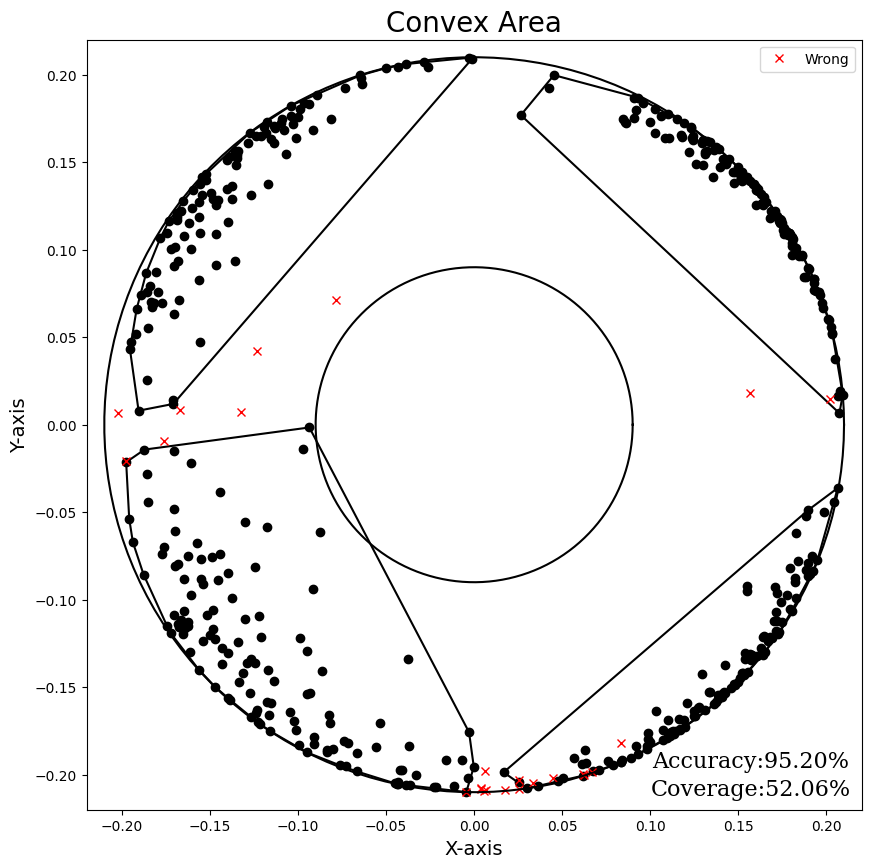

In [21]:
from utils.measure import get_measure

batch = Sampler.sample_all(test_buffer)
get_measure(batch, args.mode, True, plot_name = Path("../plots/temp.png"))